In [1]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"eliffiliz","key":"68f0b39246dc51654ff5b96323dfffe5"}'}

In [3]:
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d jessicali9530/celeba-dataset
!ls

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
100% 1.33G/1.33G [01:02<00:00, 24.4MB/s]
100% 1.33G/1.33G [01:02<00:00, 22.9MB/s]
celeba-dataset.zip  kaggle.json  sample_data


In [5]:
!cd /content
!mkdir ./celeba
!unzip /content/celeba-dataset.zip -d /content/celeba

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: /content/celeba/img_align_celeba/img_align_celeba/197604.jpg  
  inflating: /content/celeba/img_align_celeba/img_align_celeba/197605.jpg  
  inflating: /content/celeba/img_align_celeba/img_align_celeba/197606.jpg  
  inflating: /content/celeba/img_align_celeba/img_align_celeba/197607.jpg  
  inflating: /content/celeba/img_align_celeba/img_align_celeba/197608.jpg  
  inflating: /content/celeba/img_align_celeba/img_align_celeba/197609.jpg  
  inflating: /content/celeba/img_align_celeba/img_align_celeba/197610.jpg  
  inflating: /content/celeba/img_align_celeba/img_align_celeba/197611.jpg  
  inflating: /content/celeba/img_align_celeba/img_align_celeba/197612.jpg  
  inflating: /content/celeba/img_align_celeba/img_align_celeba/197613.jpg  
  inflating: /content/celeba/img_align_celeba/img_align_celeba/197614.jpg  
  inflating: /content/celeba/img_align_celeba/img_align_celeba/197615.jpg  
  inflating: /content/celeba/img_align_ce

In [6]:
!mkdir /content/celeba/img_align_celeba/
!unzip -q /content/celeba/img_align_celeba.zip -d /content/celeba/img_align_celeba/

mkdir: cannot create directory ‘/content/celeba/img_align_celeba/’: File exists
unzip:  cannot find or open /content/celeba/img_align_celeba.zip, /content/celeba/img_align_celeba.zip.zip or /content/celeba/img_align_celeba.zip.ZIP.


In [7]:
!cp /content/celeba/list_attr_celeba.csv /content/celeba/img_align_celeba/img_align_celeba/list_attr_celeba.csv

main called


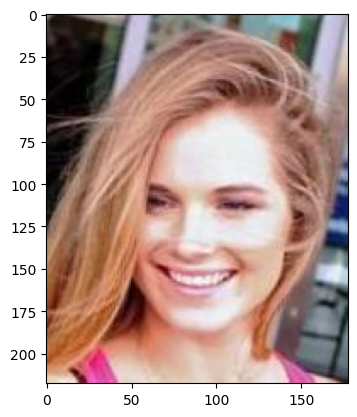

In [8]:
# check if the images and the csv are in right directories
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd

def main():
  path = '/content/celeba/img_align_celeba/img_align_celeba/001901.jpg'
  img = mpimg.imread(path)
  imgplot = plt.imshow(img)
  pd.read_csv('/content/celeba/img_align_celeba/img_align_celeba/list_attr_celeba.csv')



  print('main called')

main()

In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [11]:
!pip install tensorboardcolab

  Preparing metadata (setup.py) ... done
  Created wheel for tensorboardcolab: filename=tensorboardcolab-0.0.22-py3-none-any.whl size=3832 sha256=c4ff656e028a950a6b663169727f869ce75392e5b367f08d037683f034f81795
  Stored in directory: /root/.cache/pip/wheels/8d/ee/46/7fe2bbbf1edbcfeabfaf13962dcaadec1f631d11147fd9d34d
Successfully built tensorboardcolab


In [12]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
import pandas as pd
from PIL import Image

from tensorboardcolab import TensorBoardColab


from google.colab import drive

# Define constants
batch_size = 64 # at least 64
num_epochs = 20
input_dir = '/content/celeba/img_align_celeba/img_align_celeba/'
output_dir = '/content/gdrive/My Drive/'
csv_name = 'list_attr_celeba.csv'
num_workers = 2
image_size = 64
ngpu = 1
g_input_dim = 100
n_channels = 3
lr = 0.0002
beta1 = 0.5
visualization_step = 300
n_labels = 2
labels_number = [21,3] # Labels numers - 21: Male/Female, 3: Attractive/non Attractive

ngf = 64                    # Size of feature maps in generator
ndf = 64                    # Size of feature maps in discriminator

'''
Custom Dataset in order to load multiple labels from the csv containing labels
'''
class MyCustomDataset(torch.utils.data.Dataset):
# __init__ function is where the initial logic happens like reading a csv
# labels number should be an array of integers containing the number of the columns to take from the csv, like [19,13,8]
    def __init__(self, input_dir, csv_name, image_size, labels_number):

        # Create the transformation that will be applied: Resize, CenterCrop, ToTensor and Normalize
        self.transform_to_apply = transforms.Compose([ transforms.Resize(image_size),
            transforms.CenterCrop(image_size), transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

        # Read the csv file
        self.data_info = pd.read_csv(os.path.join(input_dir,csv_name))

        # First column contains the image paths, second column is the labels
        self.image_arr = np.asarray(self.data_info.iloc[:, 0])

        # Create the temporary array with the labels specified, initialize it at random
        temp_labels = np.random.rand(self.image_arr.shape[0], len(labels_number))

        # For every label that we want to use we load the corresponding csv coloumn in the temporary variable
        for i in range(len(labels_number)):
            temp_labels[0:-1,i] = (self.data_info.iloc[0:-1, labels_number[i] ] )

        # Defenetively save the labels array, that will contains only the interesting labels
        self.label_arr = np.asarray(temp_labels)

        # Calculate lenght of the dataset
        self.data_len = len(self.data_info.index)


    # __getitem__ function returns the data and labels. This function is called from dataloader
    def __getitem__(self, index):

        # Get image name from the pandas df
        single_image_name = self.image_arr[index]

        # Open image and apply the transformation
        img_as_img = Image.open(os.path.join(input_dir,single_image_name))
        img = self.transform_to_apply(img_as_img)

        # Get the labels of the image based on the cropped pandas column
        single_image_label = self.label_arr[index]

        # Normalize labels between 0 and 1
        for i in range (single_image_label.size):
            if single_image_label[i] < 0:
                single_image_label[i] = 0

        return (img, single_image_label)

    def __len__(self):
        return self.data_len

# Function that will create the dataset and the dataloader and return the dataloader
def getDataLoader(input_dir,batch_size,image_size,num_workers,labels_number):

    dataset = MyCustomDataset(input_dir,csv_name,image_size,labels_number)

    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)

    return data_loader

# G(z)
class Generator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super(Generator, self).__init__()
        self.deconv1_1 = nn.ConvTranspose2d(100, d*4, 4, 1, 0)
        self.deconv1_1_bn = nn.BatchNorm2d(d*4)
        self.deconv1_2 = nn.ConvTranspose2d(n_labels*2, d*4, 4, 1, 0)
        self.deconv1_2_bn = nn.BatchNorm2d(d*4)
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 3, 4, 2, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    # def forward(self, input):
    def forward(self, input, label):
        x = F.leaky_relu(self.deconv1_1_bn(self.deconv1_1(input)), 0.2)
        y = F.leaky_relu(self.deconv1_2_bn(self.deconv1_2(label)), 0.2)
        x = torch.cat([x, y], 1)
        x = F.leaky_relu(self.deconv2_bn(self.deconv2(x)), 0.2)
        x = F.leaky_relu(self.deconv3_bn(self.deconv3(x)), 0.2)
        x = F.leaky_relu(self.deconv4_bn(self.deconv4(x)), 0.2)
        x = torch.tanh(self.deconv5(x))

        return x

class Discriminator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super(Discriminator, self).__init__()
        self.conv1_1 = nn.Conv2d(3, int(d/2), 4, 2, 1)
        self.conv1_2 = nn.Conv2d(n_labels*2, int(d/2), 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d*8)
        self.conv5 = nn.Conv2d(d*8, 1, 4, 1, 0)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    # def forward(self, input):
    def forward(self, input, label):
        x = F.leaky_relu(self.conv1_1(input), 0.2)
        y = F.leaky_relu(self.conv1_2(label), 0.2)
        x = torch.cat([x, y], 1)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = torch.sigmoid(self.conv5(x))

        return x

def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

# function to get the labels as tensor for the discriminator from the real labels in a vector
def getDiscriminatorLabels(lbl, batch_size, image_size):

    if(lbl.shape[1] == 1):

        a = torch.zeros([batch_size,2,image_size,image_size])

        for i in range(batch_size):
            if lbl[i][0] == 1:
                a[i,0,:,:] = 1
            else :
                a[i,1,:,:] = 1

        return a

    elif (lbl.shape[1] == 2):

        a = torch.zeros([batch_size,4,image_size,image_size])

        for i in range(batch_size):
          if lbl[i][0] == 1:
                a[i,0,:,:] = 1
          else :
                a[i,1,:,:] = 1
          if lbl[i][1] == 1:
                a[i,2,:,:] = 1
          else :
                a[i,3,:,:] = 1

        return a

    else:
        a = torch.zeros([batch_size,6,image_size,image_size])

        for i in range(batch_size):
          if lbl[i][0] == 1:
                a[i,0,:,:] = 1
          else :
                a[i,1,:,:] = 1
          if lbl[i][1] == 1:
                a[i,2,:,:] = 1
          else :
                a[i,3,:,:] = 1
          if lbl[i][2] == 1:
                a[i,4,:,:] = 1
          else :
                a[i,5,:,:] = 1

        return a

# function to get the labels as tensor for the generator from the random labels in a vector
def getGeneratorLabels(lbl,batch_size):

    if(lbl.shape[1] == 1) :

        a = torch.zeros([batch_size,2,1,1])

        for i in range(batch_size):
            if lbl[i][0] == 1:
                a[i,1,0,0] = 1
            else:
                a[i,0,0,0] = 1

        return a

    elif(lbl.shape[1] == 2):
        a = torch.zeros([batch_size,4,1,1])

        for i in range(batch_size):
            if lbl[i][0] == 1:
                a[i,1,0,0] = 1
            else:
                a[i,0,0,0] = 1
            if lbl[i][1] == 1:
                a[i,3,0,0] == 1
            else:
                a[i,2,0,0] == 1

        return a
    else:
        a = torch.zeros([batch_size,6,1,1])

        for i in range(batch_size):
            if lbl[i][0] == 1:
                a[i,1,0,0] = 1
            else:
                a[i,0,0,0] = 1
            if lbl[i][1] == 1:
                a[i,3,0,0] == 1
            else:
                a[i,2,0,0] == 1
            if lbl[i][2] == 1:
                a[i,5,0,0] = 1
            else:
                a[i,4,0,0] = 1

        return a

# get the generator labels in a tensor for the generator in order to have a grid of 8x8
# generated images with alternatig labels
def getGeneratorVisualizationLabels(n_features,batch_size):
    remaining = batch_size - 64

    if n_features == 1:

        zeros = np.zeros((32,1))
        ones = np.ones((32,1))

        if remaining > 0:
            lbl_tmp = np.concatenate((zeros,ones),axis=0)
            remaining_zeros = np.zeros((remaining,1))
            lbl = np.concatenate((lbl_tmp,remaining_zeros),axis = 0)
        else:
            lbl = np.concatenate((zeros,ones),axis=0)

        lbl = getGeneratorLabels(lbl,batch_size)
        return lbl
    elif n_features == 2:
        zeros = np.zeros((16,1))
        ones = np.ones((16,1))
        c1 = np.concatenate((zeros,ones,zeros,ones),axis =0)
        c2 = np.concatenate((zeros,zeros,ones,ones),axis =0)
        lbl = np.concatenate((c2,c1),axis=1)

        if(remaining >0):
          remaining_zeros = np.zeros((remaining,2))
          lbl = np.concatenate((lbl,remaining_zeros),axis = 0)

        return getGeneratorLabels(lbl,batch_size)
    else:
        zeros = np.zeros((8,1))
        ones = np.ones((8,1))
        c1 = np.concatenate((zeros,ones,zeros,ones,zeros,ones,zeros,ones),axis =0)
        c2 = np.concatenate((zeros,zeros,ones,ones,zeros,zeros,ones,ones),axis =0)
        c3 = np.concatenate((zeros,zeros,zeros,zeros,ones,ones,ones,ones),axis =0)
        lbl = np.concatenate((c3,c2,c1),axis=1)

        if(remaining >0):
          remaining_zeros = np.zeros((remaining,3))
          lbl = np.concatenate((lbl,remaining_zeros),axis = 0)

        return getGeneratorLabels(lbl,batch_size)


# Main Program
def main():
    # Decide which device we want to run on
    device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
    print("Use device: " + str(device))

    tb = TensorBoardColab(graph_path='/log')
    visualization_name='CELEBA-GAN-1'

    # Load data
    data_loader = getDataLoader(input_dir, batch_size, image_size, num_workers,labels_number)

    # Save a sample of the training data
    show_images = next(iter(data_loader))
    plt.imshow(np.transpose(vutils.make_grid(show_images[0][0:64], padding=2, normalize=True),(1,2,0)))
    plt.savefig(str(output_dir) + 'training_sample' + '.png')

    # Create the Generator
    netG = Generator().to(device)
    print(netG)

    # Create the Discriminator
    netD = Discriminator().to(device)
    print(netD)

    # Set the cost function
    cost_fun = nn.BCELoss()

    real_label = 1
    fake_label = 0

    # Create Discriminator and Generator optimizer
    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

    # Start traiting
    for current_epoch in range(num_epochs):

        for batch_index, (data,lbl) in enumerate(data_loader,0):
            # Encode real labels for the discriminator
            lbl_real_disc = getDiscriminatorLabels(lbl,batch_size, image_size)

            # Reset discriminator, the same as optimizerD.zero_grad()
            netD.zero_grad()
            # Train discriminator on real data
            real_data = data.to(device) #load the real data in the data variable
            lbl_real_disc = lbl_real_disc.to(device)
            # create a tensor of lenght batch size, with inside all cells the label indicating real data
            b_size = real_data.size(0)
            targets = torch.full((b_size,), real_label, device=device)
            # compute the output of the discriminator, that will be a number between 0 and 1 for every batch element
            outputs = netD(real_data,lbl_real_disc).view(-1)
            # Compute the loss of the discriminator
            real_loss = cost_fun(outputs,targets)
            # Backward propagation for the discriminator
            real_loss.backward()
            D_x = outputs.mean().item()

            # Get random labels (array of 1 or 0)
            fake_in_lbl_clear = np.random.randint(2, size=(batch_size,n_labels))

            # From the rangom labels get the labels for the generator
            fake_in_lbl_g = getGeneratorLabels(fake_in_lbl_clear,batch_size)
            fake_in_lbl_g = fake_in_lbl_g.to(device)

            # From the rangom labels get the labels for the discriminator
            fake_in_lbl_d = getDiscriminatorLabels(fake_in_lbl_clear,batch_size,image_size)
            fake_in_lbl_d = fake_in_lbl_d.to(device)

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, g_input_dim, 1, 1, device=device)
            # Generate fake image batch with G
            fake = netG(noise,fake_in_lbl_g)
            targets.fill_(fake_label)
            # Classify all fake batch with D
            output = netD(fake.detach(),fake_in_lbl_d).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = cost_fun(output, targets)
            # Calculate the gradients for this batch
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Add the gradients from the all-real and all-fake batches
            errD = errD_fake
            # Update D
            optimizerD.step()

            # Train the generator
            netG.zero_grad()
            # fake labels are real for the generator, because the objective of the discriminator
            # is to generate data that seems real, so that is labeled real
            targets.fill_(real_label)
            # Reuse fake data to make the discriminator classify again
            outputs = netD(fake,fake_in_lbl_d).view(-1)
            # The loss of the generator is the difference between the output of the discriminator and the real label
            loss_g = cost_fun(outputs,targets)
            # Generator backpropagation
            loss_g.backward()
            D_G_z2 = outputs.mean().item()
            # Generator optimizer step
            optimizerG.step()

            if batch_index % visualization_step == 0:
                print('Epoch ' + str(current_epoch) + '/' + str(num_epochs) + ' batch ' + str(batch_index) + '/' + str(len(data_loader)))

                fake_vis_label = getGeneratorVisualizationLabels(n_labels,batch_size)
                fake_vis_label = fake_vis_label.to(device)
                noise_vis = torch.randn(b_size, g_input_dim, 1, 1, device=device)
                visualFake = netG(noise_vis,fake_vis_label)
                imgplot = plt.imshow(np.transpose(vutils.make_grid(visualFake[0:64].detach().cpu(), padding=2, normalize=True),(1,2,0)))
                plt.savefig(str(output_dir) + 'result_' + str(current_epoch) + '_' + str(batch_index) + '.png')
                plt.show()

                print('Loss_D_real: ' + str(D_x) + ' Loss_D_fake: ' + str(D_G_z1) + ' Loss G: ' + str(D_G_z2) )

                current_batch = int(current_epoch*len(data_loader) + batch_index)

                tb.save_value('Loss D real',visualization_name,current_batch,float(D_x))
                tb.save_value('Loss D fake',visualization_name,current_batch,float(D_G_z1))
                tb.save_value('Loss G',visualization_name,current_batch,float(D_G_z2))

                 # Update plots
                tb.flush_line(visualization_name)


main()


Use device: cuda:0
Wait for 8 seconds...
Initialization failed, retry again (1)


Wait for 8 seconds...
Initialization failed, retry again (2)


Wait for 8 seconds...
Initialization failed, retry again (3)


Wait for 8 seconds...
Initialization failed, retry again (4)


Wait for 8 seconds...
Initialization failed, retry again (5)


Wait for 8 seconds...
Initialization failed, retry again (6)


Wait for 8 seconds...
Initialization failed, retry again (7)


Wait for 8 seconds...
Initialization failed, retry again (8)


Wait for 8 seconds...
Initialization failed, retry again (9)


Wait for 8 seconds...
Initialization failed, retry again (10)


Wait for 8 seconds...


KeyboardInterrupt: 